# Loading required packages/libraries

In [2]:
import gpetas
import numpy as np
import datetime
time_format = "%Y-%m-%d %H:%M:%S.%f"

import matplotlib.pyplot as plt

# auto reload using developer version
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Define domain
One has to specify following aspects of the domain of the data:

* time domain
    * time borders for the training T_borders_training
    * time borders for the testing T_borders_testing
    * time origin (when was '0.' days) given by a *datetime* format: '%Y-%m-%d %H:%M:%S.%f'
* spatial domain X_borders
* domain of the marks (magnitudes) usually by m0

In [3]:
#=========================================
#=========================================
### (1) Setup domain obj
#=========================================
#=========================================
# case name
case_name = 'gron'


#=========================================
# 1a) time domain
#=========================================
time_origin = '1991-12-05 00:00:00.0'
time_end = '2022-03-07 00:00:00.0'
T_borders_training = np.array([0.,11050.]) # in days

time_origin_obj = datetime.datetime.strptime(time_origin, time_format).replace(tzinfo=datetime.timezone.utc)
time_end_obj = datetime.datetime.strptime(time_end, time_format).replace(tzinfo=datetime.timezone.utc)
delta_Tall=(time_end_obj-time_origin_obj).total_seconds()/(60.*60.*24)
T_borders_all = np.array([0.,delta_Tall])
if T_borders_training[1]>delta_Tall:
    T_borders_training[1] = 0.5*delta_Tall
    print('T_borders_training[1] reset to=',T_borders_training[1])

#=========================================
# 1b) spatial domain
#=========================================
X_borders = np.array([[230829., 261993.],[568400., 612309.]]) # in km 

#=========================================
# mark domain: [m0,+inf)
#=========================================
m0 = 1.5


#=========================================
# 1c) generate domain_obj
#=========================================
domain_obj = gpetas.domain_setup.domain_class()
domain_obj.T_borders_all = T_borders_all
domain_obj.T_borders_training=T_borders_training
domain_obj.T_borders_testing = np.array([T_borders_training[1],T_borders_all[1]])
domain_obj.time_origin = time_origin
domain_obj.X_borders = X_borders
domain_obj.m0 = m0
# case_name (optional)
domain_obj.case_name = case_name
vars(domain_obj)

{'T_borders_all': array([    0., 11050.]),
 'T_borders_training': array([    0., 11050.]),
 'T_borders_testing': array([11050., 11050.]),
 'X_borders': array([[230829., 261993.],
        [568400., 612309.]]),
 'X_borders_UTM_km': None,
 'X_borders_original': None,
 'time_origin': '1991-12-05 00:00:00.0',
 'm0': 1.5,
 'case_name': 'gron'}

# 2) Data from text file with specific format

Observed data can be provided either directly 
in a text file with a specific format which ``gpetas`` can read.

* a text file with 5 columns, no header, where each row corresponds to a single event (earthquake)

    > idx, x_lon, y_lat, mag, time 

where *time* is decimal in days. Assuming N observed events, the data file has dimension (N,5), e.g.,
```
    1	2.7523	2.1859	4.6	0.000000
    2	2.7447	2.0783	3.4	0.004436
    3	3.0142	2.1734	3.4	0.320997
    4	3.4610	1.5132	3.5	2.271304
    5	2.8646	2.2552	3.4	11.108739
    6	2.8682	3.0405	4.1	41.841438
    7	2.8948	3.0755	4.9	41.963901
    8	2.6674	3.0231	3.4	42.026355
```


____________________________________________________
data_obj has been created and saved in: output/inference_results/data_obj_gron.all


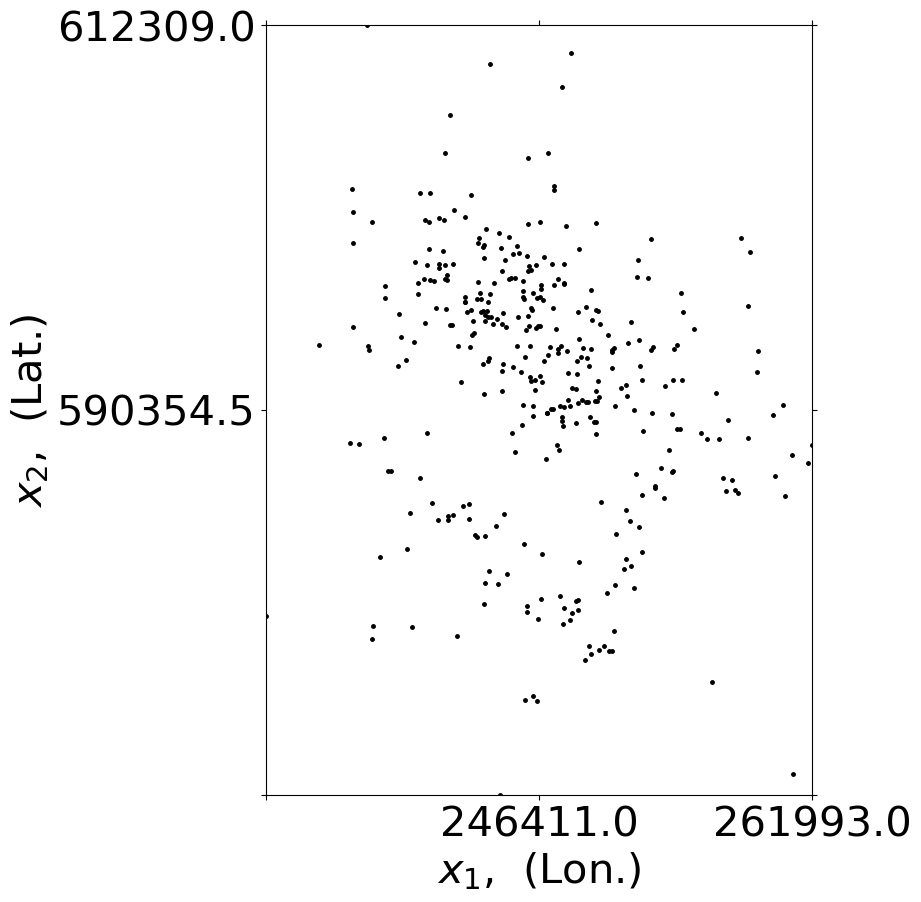

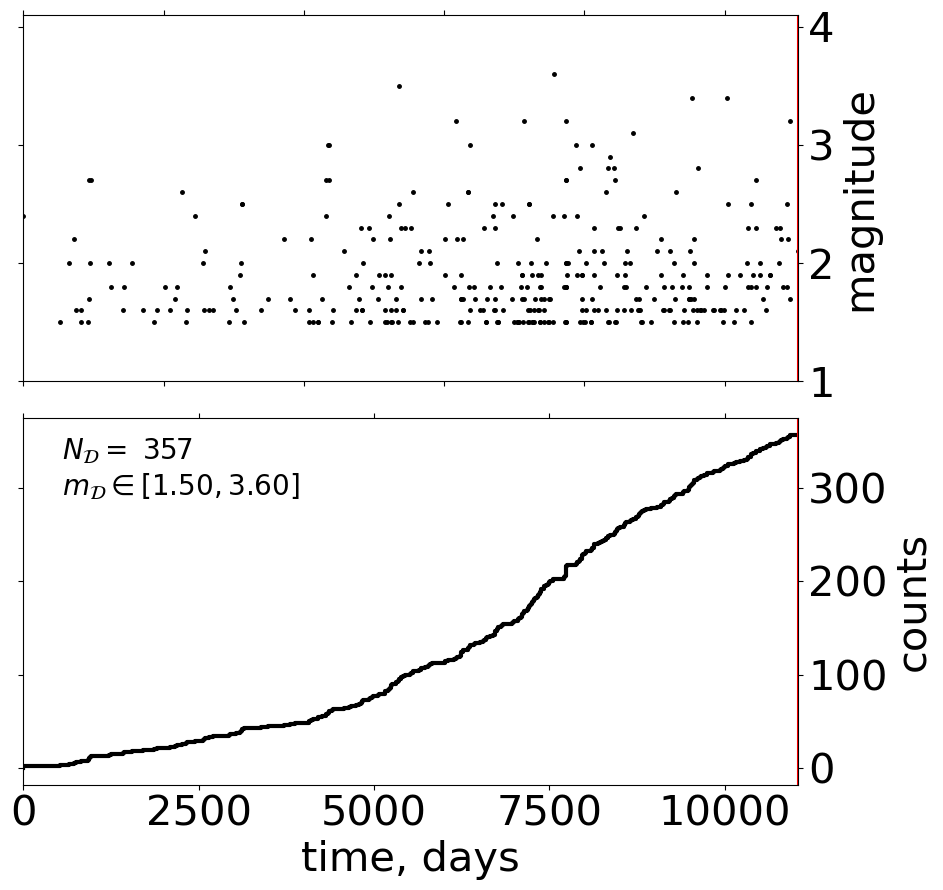

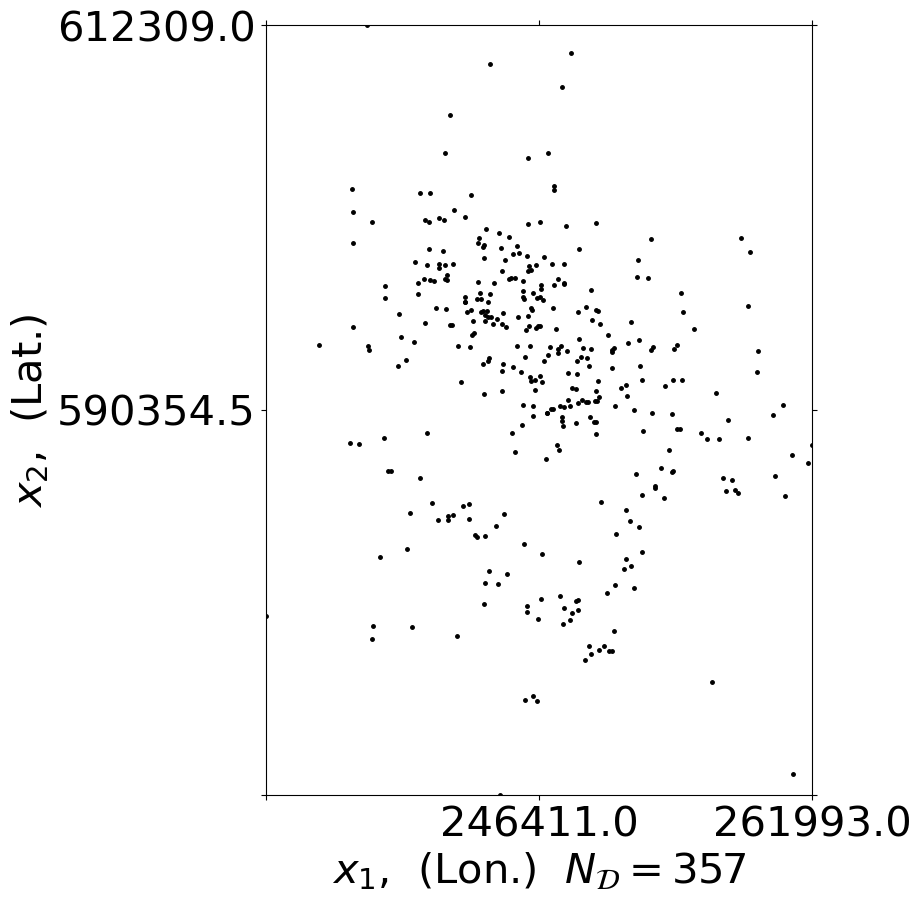

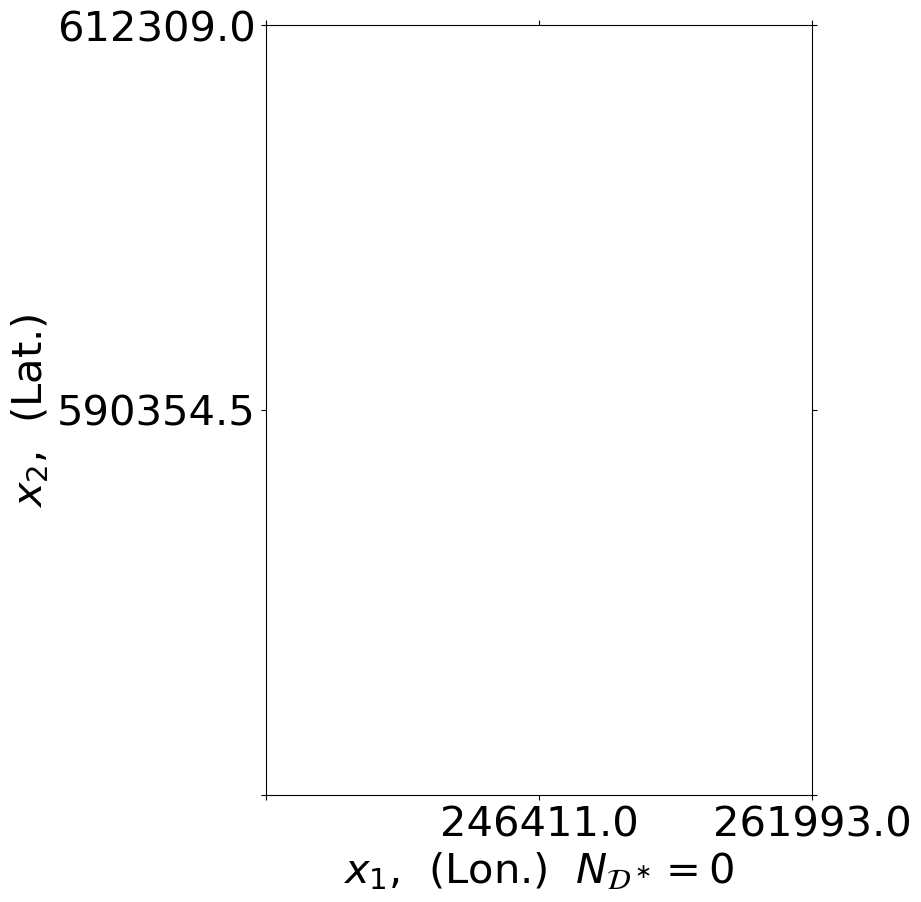

In [4]:
#=========================================
# 2) get data and automatically saves is it into './inference_results/data_obj_gron.all'
#=========================================
fname = 'data/Catalog_2022_juldat.dat' # as a string
data_obj = gpetas.some_fun.create_data_obj_from_cat_file(fname=fname,domain_obj=domain_obj,case_name=domain_obj.case_name)

#=========================================
# 2c) plots setup_obj with data and domain
#=========================================
h=gpetas.plotting.plot_setting(data_obj=data_obj)

# 3) Inference setup
In order to perform inference (Bayesian or Maximum Likelihood)
one needs to define or setup several auxiliary variables.
This is done by creating a ***setup_obj*** for the inference which 
includes all required information of the
* Bayesian inference, i.e., Gibbs sampling procedure with Gaussian process 
modelling of the background intensity (GP-ETAS, gpetas) or
* classical Maximum Likelihood estimation (MLE) using a kernel density estimator 
for the background intensity

## 3.1) Setup object for Bayesian inference (Gibbs sampler)
Sampling the posterior requires a
*setup_obj*, which contains everything
one needs for inference: data, domain definition, setup variables (Gibbs sampling parameters).

The inference procedure requires the following:
* Specification of the ***domain*** of the analysis specified in *domain_obj* which is included in the *data_obj*
* ***Data*** stored in a *data_obj* which includes *domain_obj*
* ***parameters of the Gibbs sampler***, e.g., burn-in, number of posterior samples, start values etc. saved in *setup_obj*

In [5]:
#=========================================
#=========================================
### (3.1) Setup object of the Gibbs sampler
#=========================================
#=========================================
# special for Groningen:
# priors
# start values for theta_offspring: d0
# maybe adjusting cov_params?


#=========================================
# 3.1a) Loading data_obj which includes
#                        domain_obj
#=========================================
case_name = 'gron'
fname = 'output/inference_results/data_obj_%s.all'%(case_name) #prevously in 2) generated and saved
data_obj = np.load(fname,allow_pickle=True)


#=========================================
# 3.1b) variables of the Gibbs sampler
#=========================================
# sampler parameters
burnin = 10#5000                               # number of discared initial samples. default: 5000
Ksamples = 10#1000                             # number of samples of the joint posterior default: 500 (a few hundreds)
thinning = 1#20                              # default:10 # or 20:thinning of the obtained samples in order to avoid autocorrelation
MH_proposals_offspring = 100               # Number of MH proposals for offspring params
MH_cov_empirical_yes = None                # using empirical cov for proposal distribution
sigma_proposal_offspring_params = None     # uses default values: 0.01**2 # alternatives:0.03**2
kth_sample_obj = None                      # starting sampling from kth sample 
num_iterations = Ksamples*thinning+1
print('#iters',num_iterations)


# offspring
stable_theta_sampling = 'yes'              # constraint on theta that only stable Hawkes processes are allowed
prior_theta_dist = 'uniform'               # specifies prior distribution either 'gamma' or 'uniform'
prior_theta_params = np.array(             # from Gerts paper
    [[1e-7, 0.06], [0.001, 1], [1.0, 1.3], 
    [np.log(10)*0.6, np.log(10)*1.], 
    [1e-7, 50000], [1e-7, 5], [1., 5]])
theta_start_Kcpadgq = None                 # uses default values:
if case_name=='gron':                      # particular start values for Groningen especially d0
    d0 = 100.
    theta_start_Kcpadgq = np.array([0.0025, 0.01, 1.2, 1.8,d0 , 0.5, 2.])
spatial_offspring = 'R'                    # alternatives: 'G' gaussian 


# background: 
cov_params = None                          # start values of hypers, uses default: silverman rule
mu_nu0 = None                              # mean of hyper prior on nu_0, uses default value:



# background: spatial resolution for plotting/evaluations
ngrid_per_dim = 50                         # default value: 50 corresponds to a 50x50 grid over X domain
X_grid = gpetas.some_fun.make_X_grid(data_obj.domain.X_borders, nbins=ngrid_per_dim)
                                           # generates spatial grid for plotting etc.
    
# general 
time_origin = data_obj.domain.time_origin
case_name = data_obj.case_name
    
# save results
output_dir = './output/inference_results'
outdir = output_dir


# Generating GS sampler setup_obj
setup_obj = gpetas.setup_Gibbs_sampler.setup_sampler(data_obj=data_obj,
             utm_yes=None,
             spatial_offspring=spatial_offspring,
             theta_start_Kcpadgq=theta_start_Kcpadgq,
             sigma_proposal_offspring_params=sigma_proposal_offspring_params,
             ngrid_per_dim=ngrid_per_dim,
             cov_params=cov_params,
             mu_nu0=None,
             X_grid=X_grid,
             outdir=outdir,
             prior_theta_dist=prior_theta_dist,
             prior_theta_params=prior_theta_params,
             stable_theta_sampling=stable_theta_sampling,
             time_origin=time_origin,
             case_name=case_name,
             burnin=burnin, 
             Ksamples=Ksamples,
             num_iterations=num_iterations,
             thinning=thinning,
             MH_proposals_offspring=MH_proposals_offspring,
             MH_cov_empirical_yes=MH_cov_empirical_yes,
             kth_sample_obj=kth_sample_obj,           
             corresponding_mle={'h_min_degree':100.})

#iters 11
Output subdirectory exists
setup_obj has been created and saved: ./output/inference_results/setup_obj_gron.all
./output/inference_results subdirectory exists
mle_setup_obj has been created and saved: ./output/inference_results/setup_obj_default_gron_mle.all
h_min_silverman is selected= 2397.9451164464576
./output/inference_results subdirectory exists
mle_setup_obj has been created and saved: ./output/inference_results/setup_obj_silverman_gron_mle.all


# 4) Inference: gpetas and MLE
Inference can be done ***in the terminal*** using ``demo_inference_setup_obj_v008.py`` 
program.

This program does ***Gibbs sampling and MLE*** automatically using 
the setup of the Gibbs sampler also for MLE.

The ``demo_inference_setup_obj_v008.py`` requires only one argument, namely 
the *setup_obj file*.
Make sure that *gpetas_env* is activated first.

***Type in terminal:***

```bash
python3.9 demo_inference_setup_obj_v009.py --fsetup output/inference_results/setup_obj_gron.all
```

In order to avoid MLE computiations and only perform Gibbs sampling use the following extra options,

```bash
python3.9 demo_inference_setup_obj_v009.py --fsetup output/inference_results/setup_obj_gron.all --mle_yes no --mle_yes_silverman no
```

In [6]:
### TEST, if inference works
#GS = gpetas.Gibbs_sampler.GS_ETAS(data_obj=setup_obj.data_obj,
#        setup_obj=setup_obj,
#        burnin=setup_obj.burnin,
#        num_samples=setup_obj.num_iterations,
#        stat_background=False,
#        thinning=setup_obj.thinning,
#        kth_sample_obj=setup_obj.kth_sample_obj,
#        case_name=setup_obj.case_name,
#        MH_proposals_offspring=setup_obj.MH_proposals_offspring,
#        MH_cov_empirical_yes=setup_obj.MH_cov_empirical_yes)
#
#GS.sample()

# 5) Inference: Results
Inference results are given automatically as:
* plots in subdirectory 
***output/inference_results/figures***.
* offspring parameter values in 
***output/inference_results/tables***.
Further summaries and statistics can be computed based on the 
posterior samples which are saved in *save_obj_GS*. 
*save_obj_GS* can be loaded from a file,
```
fname = 'output/inference_results/GS_save_data_gron.bin'
save_obj_GS = np.load(fname,allow_pickle=True)
```

Figures of the results can be automatically plotted using routines
in *gpetas.plotting.plot_...*, e.g.,

In [8]:
case_name = 'gron'
fname='output/inference_results/GS_save_data_%s.bin'%case_name
save_obj_GS = np.load(fname,allow_pickle=True)
fname='output/inference_results/mle_default_hmin_%s.all'%case_name
mle_obj = np.load(fname,allow_pickle=True) #default
fname='output/inference_results/mle_silverman_hmin_%s.all'%case_name
mle_obj_silverman = np.load(fname,allow_pickle=True)

testing periods
[[    0. 11050.]
 [11050. 11050.]] days.
Number of employed posterior samples: 20
Current T_star_testing = [    0. 11050.]
Employed number of posterior samples: 20
Current T_star_testing = [11050. 11050.]
Employed number of posterior samples: 20
===============Numbers==============================================
gpetas: [-8694.58939555     0.        ] Events: [357.   0.]
MLE: [-8697.97277579] [0.] Events: 357 0
MLE: [-8704.1453574] [0.] Events: 357 0


(<Figure size 1000x750 with 2 Axes>, <Figure size 1000x400 with 2 Axes>)

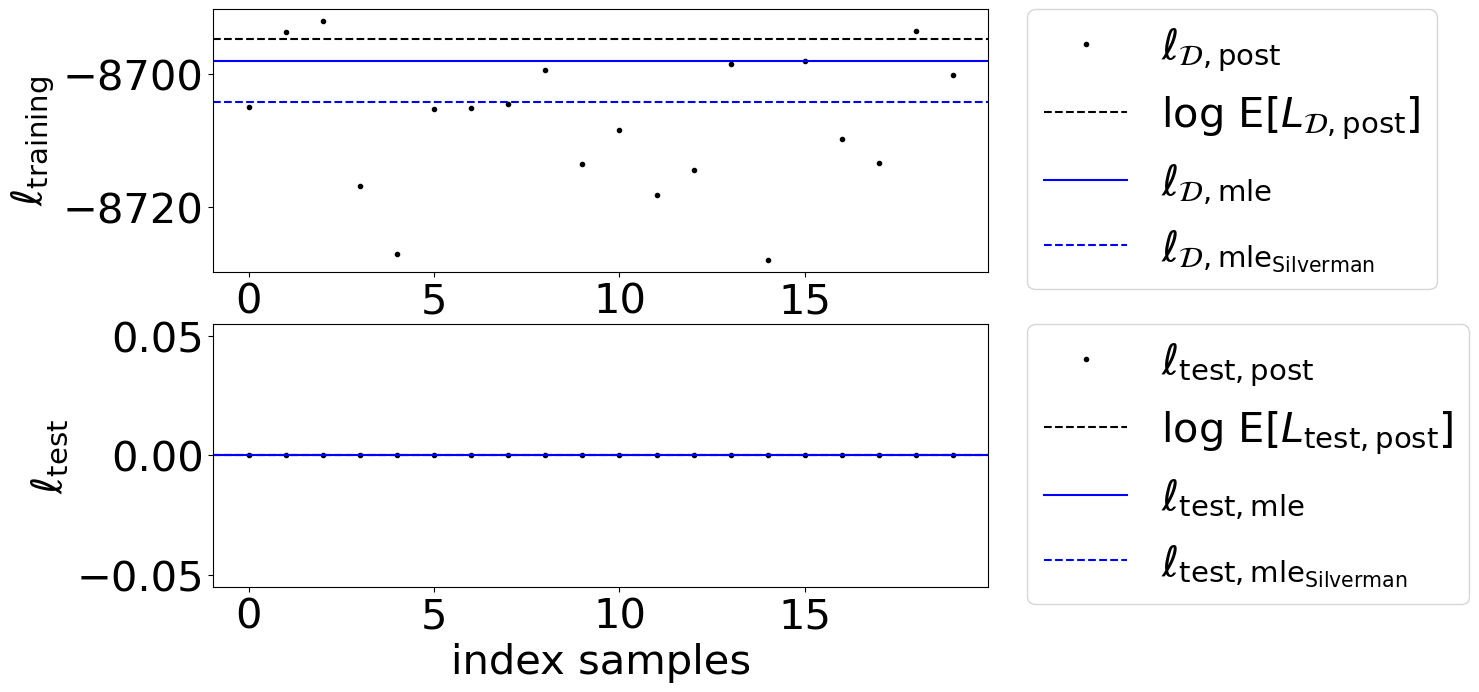

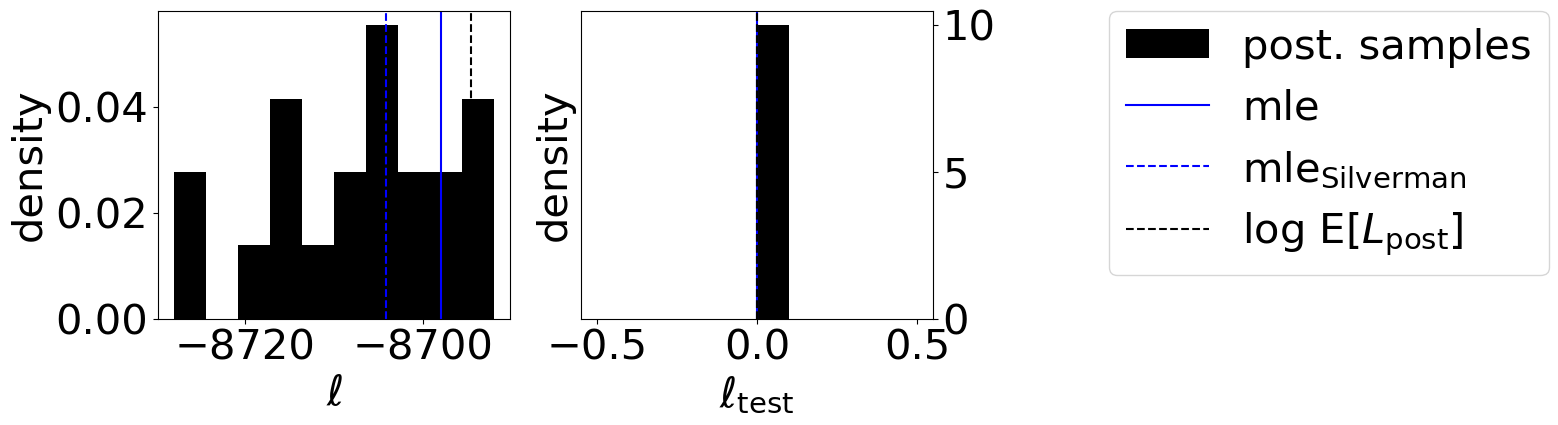

In [9]:
gpetas.plotting.plot_l_ltest(save_obj_GS=save_obj_GS,mle_obj=mle_obj,mle_obj_silverman=mle_obj_silverman)

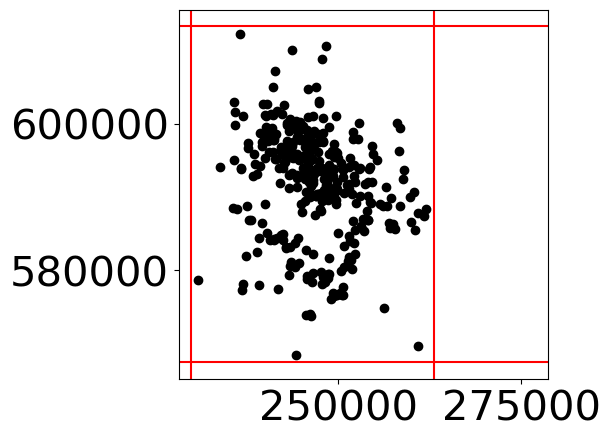

[[229829. 262993.]
 [567400. 613309.]]


In [10]:
# Heuristics for the definition of spatial domain
# 0) Raw data from text file
# case name
case_name = 'gron'

# raw data
fname_rawdata = './data/Catalog_2022_juldat.dat'

### heuristics of determination of spatial domain
# 1 kilometer buffer zone arround maximum positions of the data
# space domain
#array([[230829., 261993.],
#       [568400., 612309.]])
rd = np.loadtxt(fname_rawdata)
dx = 1000.
dy = 1000.
x_low, x_up = np.min(rd[:,1])-dx, np.max(rd[:,1])+dx
y_low, y_up = np.min(rd[:,2])-dy, np.max(rd[:,2])+dy
region = np.array([
    [x_low, y_up],
    [x_up, y_up],
    [x_up, y_low],
    [x_low, y_low],
    [x_low, y_up]])
X_borders = np.array([[np.min(region[:, 0]), np.max(region[:, 0])], [np.min(region[:, 1]), np.max(region[:, 1])]])
bins_Xgrid = 50


plt.figure()
plt.plot(rd[:,1],rd[:,2],'ok')
plt.axhline(y=X_borders[1,0],color='r')
plt.axhline(y=X_borders[1,1],color='r')
plt.axvline(x=X_borders[0,0],color='r')
plt.axvline(x=X_borders[0,1],color='r')
plt.axis('square')
plt.show()

print((X_borders))

